# Import modules and MNIST data

In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


## First 10 training digits:

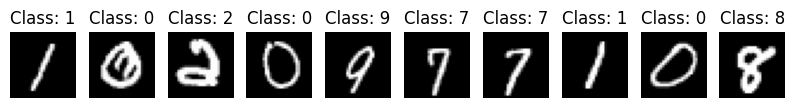

In [2]:
plt.figure(figsize=(10, 1))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# NN model setup

In [3]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [4]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [5]:
def show_failures(model, dataloader, bs, lr, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    # print('Showing max', maxtoshow, 'first failures. '
        #   'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow*0.75, 1), layout="constrained")
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1
    plt.suptitle(f'Failures for bs = {bs}, lr = {lr}', fontsize=16)

# Train Basic Model with ReLU Activation and no Dropout

In [6]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

bs = 64, lr = 0.05, final epoch 5: training loss: 0.11420567549268405, accuracy: 96.69583333333334
bs = 64, lr = 0.1, final epoch 5: training loss: 0.092786155877014, accuracy: 97.20625000000001
bs = 128, lr = 0.1, final epoch 5: training loss: 0.11372797091305256, accuracy: 96.63958333333333
bs = 256, lr = 0.2, final epoch 5: training loss: 0.11567208628625945, accuracy: 96.6
CPU times: user 6min 28s, sys: 55.9 s, total: 7min 24s
Wall time: 1min 25s


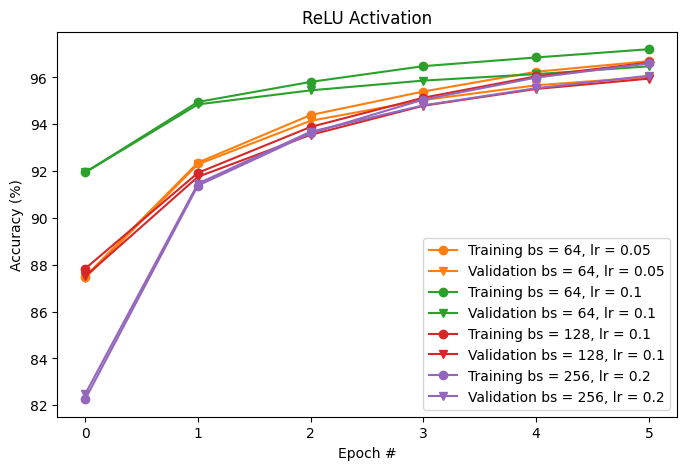

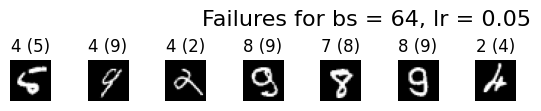

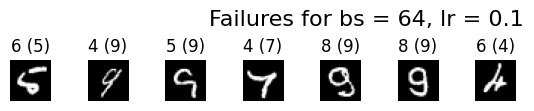

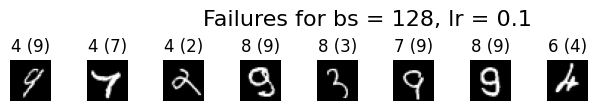

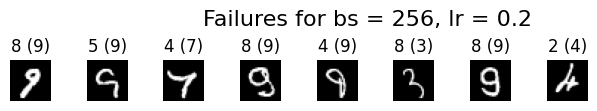

In [7]:
%%time

epochs = 6
batch_size_test = 256
batch_size = [64, 128, 256]
learning_rate = [0.05, 0.1, 0.2]
color = ['C1','C2','C3','C4','C5']

fig,ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel('Epoch #')
ax.set_ylabel('Accuracy (%)')
ax.set_title('ReLU Activation')

c = 0
for lr in range(len(learning_rate)):
    for bs in range(len(batch_size)):
        if bs == 1 and lr == 0: # found that this is a bad combo during testing
            continue
        if (bs == 0 or bs == 1) and (lr == 2):
            continue
        if (lr == 0 or lr == 1) and (bs == 2):
            continue

        # The dataloader makes our dataset iterable 
        train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size[bs])
        val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size[bs])
        
        train_acc_all = []
        val_acc_all = []

        nonlinear_model = NonlinearClassifier()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate[lr])

        for j in range(epochs):
            train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
            
            # checking on the training loss and accuracy once per epoch
            acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
            train_acc_all.append(acc)
            # print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
            
            # checking on the validation loss and accuracy once per epoch
            val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
            val_acc_all.append(val_acc)
            # print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

        print(f"bs = {batch_size[bs]}, lr = {learning_rate[lr]}, final epoch {j}: training loss: {loss}, accuracy: {acc}")
        ax.plot(range(epochs), train_acc_all, color=color[c], marker='o', label = f'Training bs = {batch_size[bs]}, lr = {learning_rate[lr]}')
        ax.plot(range(epochs), val_acc_all, color=color[c], marker='v', label = f'Validation bs = {batch_size[bs]}, lr = {learning_rate[lr]}')
        ax.legend()
        c = c + 1
        
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
        show_failures(nonlinear_model, test_dataloader, batch_size[bs], learning_rate[lr])

# Try tanh Activation Function

In [8]:
class NonlinearClassifierTanh(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
            # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
            # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

bs = 64, lr = 0.05, final epoch 5: training loss: 0.12209667098522187, accuracy: 96.54374999999999
bs = 64, lr = 0.1, final epoch 5: training loss: 0.07787469304849703, accuracy: 97.7
bs = 128, lr = 0.1, final epoch 5: training loss: 0.1235006836950779, accuracy: 96.44166666666666
bs = 256, lr = 0.2, final epoch 5: training loss: 0.1368375417003606, accuracy: 96.04791666666667
CPU times: user 6min 25s, sys: 1min 12s, total: 7min 37s
Wall time: 1min 33s


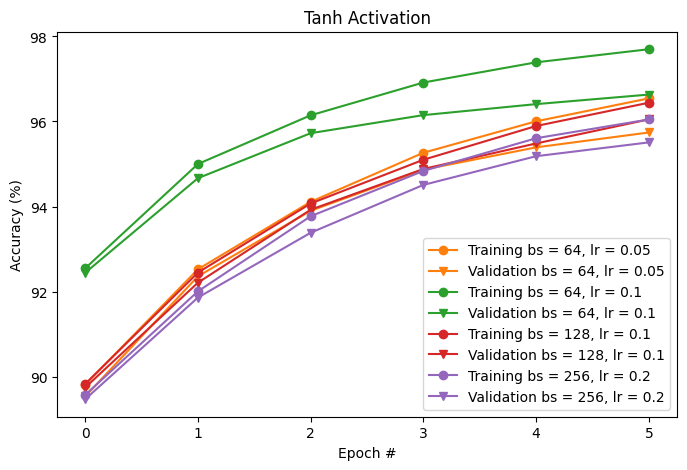

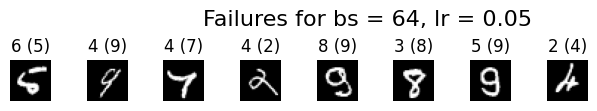

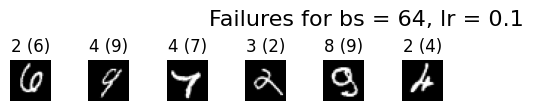

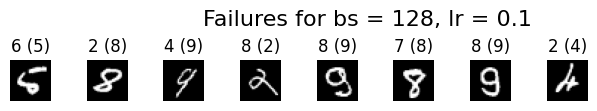

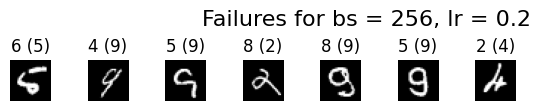

In [9]:
%%time

epochs = 6
batch_size_test = 256
batch_size = [64, 128, 256]
learning_rate = [0.05, 0.1, 0.2]
color = ['C1','C2','C3','C4','C5']

fig,ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel('Epoch #')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Tanh Activation')

c = 0
for lr in range(len(learning_rate)):
    for bs in range(len(batch_size)):
        if bs == 1 and lr == 0: # found that this is a bad combo during testing
            continue
        if (bs == 0 or bs == 1) and (lr == 2):
            continue
        if (lr == 0 or lr == 1) and (bs == 2):
            continue

        # The dataloader makes our dataset iterable 
        train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size[bs])
        val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size[bs])
        
        train_acc_all = []
        val_acc_all = []

        nonlinear_model = NonlinearClassifierTanh()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate[lr])

        for j in range(epochs):
            train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
            
            # checking on the training loss and accuracy once per epoch
            acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
            train_acc_all.append(acc)
            # print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
            
            # checking on the validation loss and accuracy once per epoch
            val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
            val_acc_all.append(val_acc)
            # print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

        print(f"bs = {batch_size[bs]}, lr = {learning_rate[lr]}, final epoch {j}: training loss: {loss}, accuracy: {acc}")
        ax.plot(range(epochs), train_acc_all, color=color[c], marker='o', label = f'Training bs = {batch_size[bs]}, lr = {learning_rate[lr]}')
        ax.plot(range(epochs), val_acc_all, color=color[c], marker='v', label = f'Validation bs = {batch_size[bs]}, lr = {learning_rate[lr]}')
        ax.legend()
        c = c + 1
        
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
        show_failures(nonlinear_model, test_dataloader, batch_size[bs], learning_rate[lr])

# Try tanh Activation Function with Dropout

In [10]:
class NonlinearClassifierTanhDrop(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
            # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
            # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

bs = 64, lr = 0.05, final epoch 5: training loss: 0.11695220600813627, accuracy: 96.62291666666667
bs = 64, lr = 0.1, final epoch 5: training loss: 0.08350385786220431, accuracy: 97.5
bs = 128, lr = 0.1, final epoch 5: training loss: 0.1261148163676262, accuracy: 96.33125
bs = 256, lr = 0.2, final epoch 5: training loss: 0.15067624673247337, accuracy: 95.4375
CPU times: user 6min 15s, sys: 1min 9s, total: 7min 24s
Wall time: 1min 21s


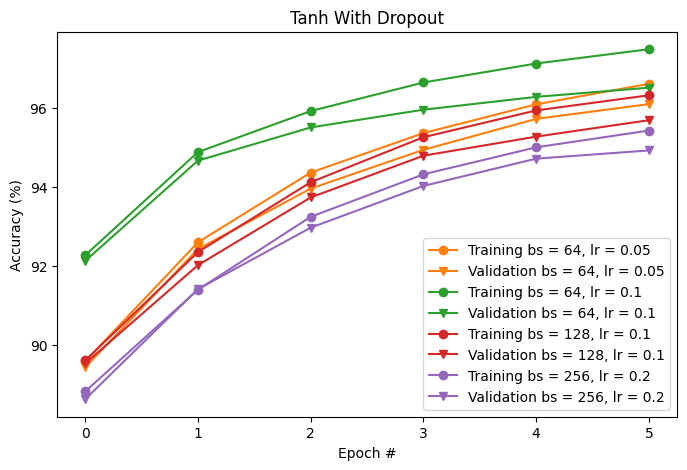

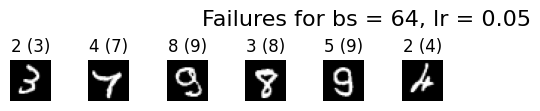

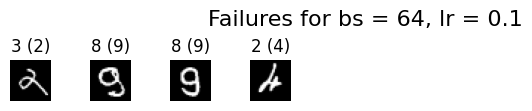

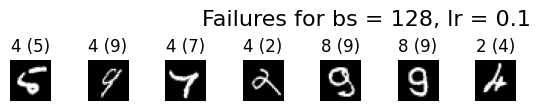

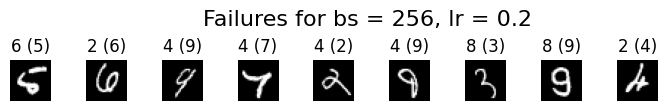

In [11]:
%%time

epochs = 6
batch_size_test = 256
batch_size = [64, 128, 256]
learning_rate = [0.05, 0.1, 0.2]
color = ['C1','C2','C3','C4','C5']

fig,ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel('Epoch #')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Tanh With Dropout')

c = 0
for lr in range(len(learning_rate)):
    for bs in range(len(batch_size)):
        if bs == 1 and lr == 0: # found that this is a bad combo during testing
            continue
        if (bs == 0 or bs == 1) and (lr == 2):
            continue
        if (lr == 0 or lr == 1) and (bs == 2):
            continue

        # The dataloader makes our dataset iterable 
        train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size[bs])
        val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size[bs])
        
        train_acc_all = []
        val_acc_all = []

        nonlinear_model = NonlinearClassifierTanhDrop()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate[lr])

        for j in range(epochs):
            train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
            
            # checking on the training loss and accuracy once per epoch
            acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
            train_acc_all.append(acc)
            # print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
            
            # checking on the validation loss and accuracy once per epoch
            val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
            val_acc_all.append(val_acc)
            # print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

        print(f"bs = {batch_size[bs]}, lr = {learning_rate[lr]}, final epoch {j}: training loss: {loss}, accuracy: {acc}")
        ax.plot(range(epochs), train_acc_all, color=color[c], marker='o', label = f'Training bs = {batch_size[bs]}, lr = {learning_rate[lr]}')
        ax.plot(range(epochs), val_acc_all, color=color[c], marker='v', label = f'Validation bs = {batch_size[bs]}, lr = {learning_rate[lr]}')
        ax.legend()
        c = c + 1
        
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
        show_failures(nonlinear_model, test_dataloader, batch_size[bs], learning_rate[lr])

# Discussion

Overall, tanh without dropout gave the highest training accuracy of 97.7%. However, the model may be overfitting due to the noticeable delta between the training and validation accuracy.

From this small sample size, it seems like linearly increasing the batch size and learning rate at the same time yields pretty similar learning curves.